In [46]:
# Load Vine dataset from scikit-learn

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch


# Load dataset
wine = load_wine()

# Print dataset description
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

In [47]:
# Create Dataframe from dataset
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [48]:
# y is alcohol values
y = df["alcohol"]
# X is other values
X = df.drop("alcohol", axis=1)

In [49]:
# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

X = pd.DataFrame(data=x_scaled, columns=X.columns)
X.head()

,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [50]:
# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [51]:
X.shape, y.shape

((178, 12), (178,))

# Netzarchitektur
Ein paar Gedanken zur Architektur

* shape von x: 178, 12 --> 178 rows und 12 colums
* Wieviele Input-Neurinen bracuhen wir? --> 12
* Wieviele Output-Neuronen brauchen wir? --> 1

Hiddenlayer je nach Geschmack. z.N. ein Hiddenlayer mit 30 Neuronen

## w1

Welches shape braucht w1?
w1 geht von 12 Neuronen auf 30 Neuronen, d.h. w1 braucht den shape (12, 30)

## w2
Welches shape braucht 2? w2 geht von 30 Neuronen auf 1 Neuron --> shape (30, 1)

# Neural Network

In [52]:
# Define Learning Rate
lr = 0.00001

# Define number of epochs
epochs = 50000

# Define Losses
losses = []

# Define RMSE
rmse = []

# Define Hidden Layer
hidden_layer = 30

# x für neuronales netz in Tensor umwandeln
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float)

# y für neuronales netz in Tensor umwandeln
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)

w1=torch.normal(std=1, mean=0, size=(12, hidden_layer), requires_grad=True)
w2=torch.normal(std=1, mean=0, size=(hidden_layer, 1), requires_grad=True)

# Bias
b1 = torch.tensor(1.0, requires_grad=True)
b2 = torch.tensor(1.0, requires_grad=True)



def relu(x):
 return torch.max(torch.tensor(0.0), x)

for i in range(epochs):
  z2 = x_train_tensor@w1+b1
  a2 = relu(z2)
  z3 = a2@w2+b2
  y_hat = relu(z3)

  loss = ((y_train_tensor - y_hat)**2).mean()
  losses.append(loss.item())

  y_test_hat = relu(relu(x_test@w1+b1)@w2+b2)
  rmse.append(mean_squared_error(y_test, y_test_hat.detach().numpy(), squared=False))

  loss.backward()

  with torch.no_grad():
    w1.sub_(w1.grad*lr)
    w2.sub_(w2.grad*lr)
    b1.sub_(b1.grad*lr)   # Backpropagation    b1 = b1 - (b1.Ableitung * Lernrate)
    b2.sub_(b2.grad*lr)   # Backpropagation    b2 = b2 - (b2.Ableitung * Lernrate)
    w1.grad.zero_()       # Gradients wieder auf 0 setzen
    w2.grad.zero_()       # Gradients wieder auf 0 setzen
    b1.grad.zero_()       # Gradients wieder auf 0 setzen
    b2.grad.zero_()       # Gradients wieder auf 0 setzen

import matplotlib.pyplot as plt

plt.plot(losses)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

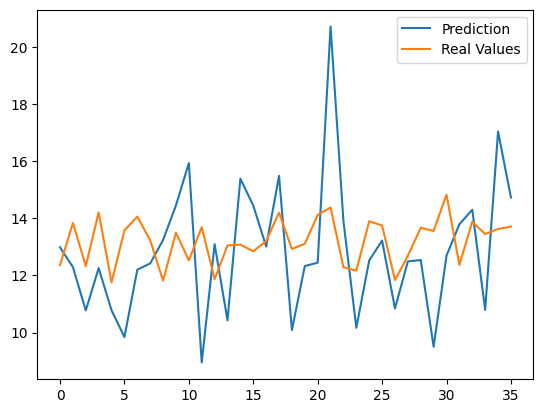

In [ ]:
# Testen des Netzes
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float)

prediction_items = []

for i in range(len(x_test_tensor)):
    z2 = x_test_tensor[i]@w1+b1
    a2 = relu(z2)
    z3 = a2@w2+b2
    y_hat = relu(z3)
    prediction_items.append(y_hat.item())

# Plot Prediction and Real Values
plt.plot(prediction_items, label="Prediction")
plt.plot(y_test.values, label="Real Values")
plt.legend()
plt.show()



In [ ]:
# No Clue
y_hat = relu(relu(x_test@w1+b1)@w2+b2)
rmse_test = mean_squared_error(y_test, y_hat.detach().numpy(), squared=False)
rmse_test.item()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.